In [ ]:
# [CELL 0] Setup Environment & Install Dependencies
!pip install torch numpy python-chess tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import chess
import os
import pickle
from collections import deque
import random
from tqdm import tqdm

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")
if device.type == 'cpu':
    print("⚠️ Warning: Đang chạy trên CPU. Hãy bật GPU T4 trong Runtime > Change runtime type")

# =========================
# Global Config (easy to edit)
# =========================
MODEL_PATH = '/content/drive/MyDrive/models'            # Path to read existing models/resources
SAVE_PATH = '/content/drive/MyDrive/models'            # Path to save new checkpoints/buffers/logs
MODEL_NAME_BEST = 'model_rl_best.pth'
SFT_MODEL_NAME = 'model_sft.pth'
BUFFER_NAME_LATEST = 'buffer_latest.pkl'
BUFFER_NAME_RL_LATEST = 'buffer_rl_latest.pkl'
TRAINING_LOG_NAME = 'training_log.csv'

# Derived absolute paths
MODEL_BEST_PATH = os.path.join(SAVE_PATH, MODEL_NAME_BEST)
SFT_MODEL_PATH = os.path.join(MODEL_PATH, SFT_MODEL_NAME)
BUFFER_LATEST_PATH = os.path.join(SAVE_PATH, BUFFER_NAME_LATEST)
BUFFER_RL_LATEST_PATH = os.path.join(SAVE_PATH, BUFFER_NAME_RL_LATEST)
TRAINING_LOG_PATH = os.path.join(SAVE_PATH, TRAINING_LOG_NAME)
MODEL_LATEST_PATH = os.path.join(SAVE_PATH, 'model_rl_latest.pth')
MOVE_MAP_LATEST_PATH = os.path.join(SAVE_PATH, 'move_map.pkl')

# Ensure directories exist
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_PATH, exist_ok=True)
print(f"📂 Model path (read): {MODEL_PATH}")
print(f"📂 Save path (write): {SAVE_PATH}")

# =========================
# Canonical 4672 Move Map (Hard-coded AlphaZero-style)
# =========================
def build_canonical_move_map_4672():
    move_to_idx = {}
    idx_to_move = {}
    idx = 0

    # 1. Queen Moves (8 hướng * 7 ô) = 3584 indices
    directions = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
    for from_sq in range(64):
        for d_r, d_f in directions:
            for dist in range(1, 8):
                to_rank = (from_sq // 8) + d_r * dist
                to_file = (from_sq % 8) + d_f * dist
                if 0 <= to_rank < 8 and 0 <= to_file < 8:
                    dest = to_rank * 8 + to_file
                    uci = chess.Move(from_sq, dest).uci()
                    move_to_idx[uci] = idx
                    idx_to_move[idx] = uci
                idx += 1

    # 2. Knight Moves (8 hướng) = 512 indices
    knight_moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    for from_sq in range(64):
        for d_r, d_f in knight_moves:
            to_rank = (from_sq // 8) + d_r
            to_file = (from_sq % 8) + d_f
            if 0 <= to_rank < 8 and 0 <= to_file < 8:
                dest = to_rank * 8 + to_file
                uci = chess.Move(from_sq, dest).uci()
                move_to_idx[uci] = idx
                idx_to_move[idx] = uci
            idx += 1

    # 3. Underpromotions (3 hướng * 3 loại quân) = 576 indices
    file_steps = [0, -1, 1]
    promotions = ['r', 'b', 'n']

    for from_sq in range(64):
        rank = from_sq // 8
        file = from_sq % 8

        # Xác định hướng phong cấp dựa trên vị trí quân tốt
        rank_step = 0
        if rank == 6:
            rank_step = 1  # Trắng: Lên
        elif rank == 1:
            rank_step = -1 # Đen: Xuống

        for f_step in file_steps:
            for p in promotions:
                if rank_step != 0:
                    to_rank = rank + rank_step
                    to_file = file + f_step
                    if 0 <= to_file < 8:
                        dest = to_rank * 8 + to_file
                        uci = chess.Move(from_sq, dest, promotion=chess.Piece.from_symbol(p).piece_type).uci()
                        move_to_idx[uci] = idx
                        idx_to_move[idx] = uci
                idx += 1
    return move_to_idx, idx_to_move

# Khởi tạo lại
CANONICAL_MOVE_TO_IDX, CANONICAL_IDX_TO_MOVE = build_canonical_move_map_4672()

✅ Device: cuda
📂 Model path (read): /content/drive/MyDrive/models
📂 Save path (write): /content/drive/MyDrive/models
🔍 Logic Check: Final Index reached = 4672
🔒 Canonical move map initialized: 1924 moves (Chuẩn AlphaZero)


In [ ]:
#Define Model Architecture - SmallResNet
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, num_res_blocks=6, num_channels=64, action_size=4672):
        super(SmallResNet, self).__init__()
        # Input: 32 channels (Current + History + Aux)
        self.conv_input = nn.Conv2d(32, num_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn_input = nn.BatchNorm2d(num_channels)

        # Backbone: Residual Tower
        self.res_blocks = nn.ModuleList([
            ResidualBlock(num_channels) for _ in range(num_res_blocks)
        ])

        # Policy Head (Actor)
        self.policy_conv = nn.Conv2d(num_channels, 32, kernel_size=1, stride=1, bias=False)
        self.policy_bn = nn.BatchNorm2d(32)
        self.policy_fc = nn.Linear(32 * 8 * 8, action_size)

        # Value Head (Critic)
        self.value_conv = nn.Conv2d(num_channels, 3, kernel_size=1, stride=1, bias=False)
        self.value_bn = nn.BatchNorm2d(3)
        self.value_fc1 = nn.Linear(3 * 8 * 8, 64)
        self.value_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn_input(self.conv_input(x)))
        for block in self.res_blocks:
            x = block(x)

        # Policy: Softmax
        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = p.view(-1, 32 * 8 * 8)
        policy_logits = self.policy_fc(p)  # Trả về RAW LOGITS

        # Value Head
        v = F.relu(self.value_bn(self.value_conv(x)))
        v = v.view(-1, 3 * 8 * 8)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))

        return policy_logits, v  # Trả về Logits
print("✅ SmallResNet defined")

✅ SmallResNet defined


In [ ]:
#ChessConverter - Board encoding & Move mapping (Hard-coded)
class ChessConverter:
    def __init__(self, move_to_idx=None, idx_to_move=None):
        self.piece_map = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
        }
        # Use fixed canonical map; no dynamic additions
        self.move_to_idx = move_to_idx if move_to_idx is not None else CANONICAL_MOVE_TO_IDX
        self.idx_to_move = idx_to_move if idx_to_move is not None else CANONICAL_IDX_TO_MOVE
        self.next_idx = len(self.move_to_idx)  # informational only

    def encode_move(self, move_uci):
        # Hard-coded: unknown moves are ignored
        idx = self.move_to_idx.get(move_uci, None)
        if idx is not None:
            return idx
        # This preserves the 4672 action space and supports common promotions.
        if isinstance(move_uci, str) and len(move_uci) == 5 and move_uci[-1] == 'q':
            base_uci = move_uci[:4]
            return self.move_to_idx.get(base_uci, None)
        return None

    def board_to_tensor(self, board, prev_board=None):
        tensor = np.zeros((32, 8, 8), dtype=np.float32)
        for sq, pc in board.piece_map().items():
            tensor[self.piece_map[pc.symbol()]][chess.square_rank(sq)][chess.square_file(sq)] = 1
        if prev_board:
            for sq, pc in prev_board.piece_map().items():
                tensor[self.piece_map[pc.symbol()]+12][chess.square_rank(sq)][chess.square_file(sq)] = 1
        if board.turn == chess.WHITE: tensor[24,:,:] = 1
        if board.has_kingside_castling_rights(chess.WHITE): tensor[25,:,:] = 1
        if board.has_queenside_castling_rights(chess.WHITE): tensor[26,:,:] = 1
        if board.has_kingside_castling_rights(chess.BLACK): tensor[27,:,:] = 1
        if board.has_queenside_castling_rights(chess.BLACK): tensor[28,:,:] = 1
        if board.ep_square:
            tensor[29][chess.square_rank(board.ep_square)][chess.square_file(board.ep_square)] = 1
        if board.is_repetition(1): tensor[30,:,:] = 1
        if board.is_repetition(2): tensor[31,:,:] = 1
        return tensor

print("✅ ChessConverter defined (hard-coded canonical map, with queen-promotion fallback)")

✅ ChessConverter defined (hard-coded canonical map, with queen-promotion fallback)


In [ ]:
# MCTS - Monte Carlo Tree Search
class MCTSNode:
    def __init__(self, parent=None, move=None, prior=0.0):
        self.parent = parent
        self.move = move
        self.prior = prior
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0.0

    def value(self):
        return self.value_sum / self.visit_count if self.visit_count > 0 else 0.0

    def is_leaf(self):
        return len(self.children) == 0

class MCTS:
    def __init__(self, model, device, c_puct=1.5, dirichlet_alpha=0.3, dirichlet_epsilon=0.25, fpu_mode='zero'):
        self.model = model
        self.device = device
        self.c_puct = c_puct
        self.converter = ChessConverter()
        # Root Dirichlet noise params
        self.dirichlet_alpha = dirichlet_alpha
        self.dirichlet_epsilon = dirichlet_epsilon
        # First Play Urgency: 'zero' or 'parent'
        self.fpu_mode = fpu_mode

    def search(self, board, num_simulations=10, temperature=1.0, prev_board=None, root_noise=True):
        root = MCTSNode()
        search_board = board.copy()
        initial_prev_board = prev_board

        # Expand root once and add Dirichlet noise to priors
        search_board.set_fen(board.fen())
        root_value = self._expand_and_evaluate(root, search_board, initial_prev_board)
        if root_noise and len(root.children) > 0:
            noise = np.random.dirichlet([self.dirichlet_alpha] * len(root.children))
            for (move, child), n in zip(root.children.items(), noise):
                child.prior = (1.0 - self.dirichlet_epsilon) * child.prior + self.dirichlet_epsilon * n

        for _ in range(num_simulations):
            node = root
            search_board.set_fen(board.fen())
            prev_board = initial_prev_board

            while not node.is_leaf() and not search_board.is_game_over():
                node = self._select_child(node, search_board)
                if node.move:
                    # track previous board before applying move
                    prev_for_next = search_board.copy()
                    search_board.push(node.move)
                    prev_board = prev_for_next

            if not search_board.is_game_over():
                value = self._expand_and_evaluate(node, search_board, prev_board)
            else:
                # Terminal value from the perspective of the side to move
                result = search_board.result()
                if result == "1-0":
                    value = -1.0 if search_board.turn == chess.BLACK else 1.0
                elif result == "0-1":
                    value = -1.0 if search_board.turn == chess.WHITE else 1.0
                else:
                    value = 0.0

            self._backpropagate(node, value)

        return self._get_action_probs(root, board, temperature)

    def _select_child(self, node, board):
        best_score = -float('inf')
        best_child = None

        for move, child in node.children.items():
            if move not in board.legal_moves:
                continue
            # FPU handling: if unvisited, use parent value or zero
            if child.visit_count == 0:
                q_value = node.value() if self.fpu_mode == 'parent' else 0.0
            else:
                q_value = - child.value()
            u_value = self.c_puct * child.prior * np.sqrt(max(1, node.visit_count)) / (1 + child.visit_count)
            score = q_value + u_value
            if score > best_score:
                best_score = score
                best_child = child
        return best_child if best_child else node

    def _expand_and_evaluate(self, node, board, prev_board):
        state = self.converter.board_to_tensor(board, prev_board=prev_board).reshape(1, 32, 8, 8)
        state_t = torch.FloatTensor(state).to(self.device)

        with torch.no_grad():
            policy_logits, value = self.model(state_t)

        #raw probability từ toàn bộ 4672 đầu ra
        policy = torch.softmax(policy_logits, dim=1).cpu().numpy()[0]
        value = value.cpu().item()

        #Normalize chỉ trên các nước đi hợp lệ
        legal_moves = list(board.legal_moves)
        move_probs = []
        total_prob = 0.0

        for move in legal_moves:
            move_idx = self.converter.encode_move(move.uci())
            if move_idx is not None:
                prob = policy[move_idx] # Lấy prob của nước đi này
            else:
                prob = 0.0
            move_probs.append(prob)
            total_prob += prob

        # Gán Prior đã chuẩn hóa vào Node con
        for move, prob in zip(legal_moves, move_probs):
            if total_prob > 0:
                prior = prob / total_prob 
            else:
                prior = 1.0 / len(legal_moves) # Fallback nếu model output toàn 0

            node.children[move] = MCTSNode(parent=node, move=move, prior=prior)

        return value

    def _backpropagate(self, node, value):
        while node is not None:
            node.visit_count += 1
            node.value_sum += value
            value = -value
            node = node.parent

    def _get_action_probs(self, root, board, temperature):
        action_probs = np.zeros(4672, dtype=np.float32)
        visits = []
        moves = []

        for move, child in root.children.items():
            if move in board.legal_moves:
                visits.append(child.visit_count)
                moves.append(move)

        if len(visits) == 0:
            return action_probs

        visits = np.array(visits, dtype=np.float32)
        if temperature == 0:
            probs = np.zeros(len(visits))
            probs[np.argmax(visits)] = 1.0
        else:
            visits = visits ** (1.0 / temperature)
            probs = visits / visits.sum()

        for move, prob in zip(moves, probs):
            move_idx = self.converter.encode_move(move.uci())
            if move_idx is not None:
                action_probs[move_idx] = prob

        return action_probs

print("✅ MCTS defined (fixed terminal value: side to move loses = -1)")

✅ MCTS defined (fixed terminal value: side to move loses = -1)


In [5]:
# [CELL 4] ReplayBuffer
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add_batch(self, samples):
        self.buffer.extend(samples)

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))

    def __len__(self):
        return len(self.buffer)

    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, 'wb') as f:
            pickle.dump(list(self.buffer), f)
        print(f"💾 Buffer saved: {len(self.buffer)} samples")

    def load(self, path):
        if os.path.exists(path):
            with open(path, 'rb') as f:
                data = pickle.load(f)
                self.buffer = deque(data, maxlen=self.buffer.maxlen)
            print(f"📖 Buffer loaded: {len(self.buffer)} samples")
            return True
        return False

print("✅ ReplayBuffer defined")

✅ ReplayBuffer defined


In [ ]:
# AlphaZeroTrainer
class AlphaZeroTrainer:
    def __init__(self, model, device=device, lr=0.001, weight_decay=1e-4):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.5)
        self.replay_buffer = ReplayBuffer(max_size=100000)
        self.converter = ChessConverter()
        self.use_self_play = False
        self.mcts = MCTS(model=self.model, device=device, c_puct=1.0)

    def combined_loss(self, policy_pred, value_pred, policy_target, value_target):
        # Policy loss: cross-entropy with log-softmax
        log_policy = torch.log_softmax(policy_pred, dim=1)
        policy_loss = -(policy_target * log_policy).sum(dim=1).mean()
        value_loss = nn.MSELoss()(value_pred, value_target)
        return policy_loss + value_loss, policy_loss, value_loss

    def _get_ai_policy(self, board, prev_board=None):
        state = self.converter.board_to_tensor(board, prev_board=prev_board).reshape(1, 32, 8, 8)
        state_t = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            policy_logits, _ = self.model(state_t)
        policy_probs = torch.softmax(policy_logits, dim=1).cpu().numpy()[0]
        return policy_probs

    def train_on_batch(self, batch):
        self.model.train()
        states, policies, values = zip(*batch)
        states = torch.stack([torch.FloatTensor(s) for s in states]).to(self.device)
        policies = torch.stack([torch.FloatTensor(p) for p in policies]).to(self.device)
        values = torch.FloatTensor(values).unsqueeze(1).to(self.device)

        policy_pred, value_pred = self.model(states)
        loss, policy_loss, value_loss = self.combined_loss(policy_pred, value_pred, policies, values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item(), policy_loss.item(), value_loss.item()

    def save_checkpoint(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'use_self_play': self.use_self_play,
        }, path)
        print(f"💾 Saved: {path}")

    def load_checkpoint(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        state_dict = checkpoint['model_state_dict'] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
        # Detect policy head size from checkpoint
        policy_key_w = 'policy_fc.weight'
        policy_key_b = 'policy_fc.bias'
        if policy_key_w in state_dict:
            target_action_size = state_dict[policy_key_w].shape[0]
            current_action_size = self.model.policy_fc.out_features
            if target_action_size != current_action_size:
                print(f"⚙️ Rebuilding model: checkpoint outputs={target_action_size}, current={current_action_size}")
                # Recreate model with the target action size
                new_model = SmallResNet(num_res_blocks=6, num_channels=64, action_size=target_action_size).to(self.device)
                # Replace trainer model and MCTS model reference
                self.model = new_model
                if hasattr(self, 'mcts') and self.mcts is not None:
                    self.mcts.model = self.model
                # Recreate optimizer tied to new parameters
                self.optimizer = optim.Adam(self.model.parameters(), lr=self.optimizer.param_groups[0]['lr'], weight_decay=self.optimizer.param_groups[0].get('weight_decay', 1e-4))
                # Recreate scheduler
                self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.5)
        # Load weights
        self.model.load_state_dict(state_dict)
        if isinstance(checkpoint, dict) and 'optimizer_state_dict' in checkpoint:
            try:
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            except Exception as e:
                print(f"⚠️ Optimizer state mismatch; reinitialized. Details: {e}")
        # Restore scheduler state if present
        if isinstance(checkpoint, dict) and 'scheduler_state_dict' in checkpoint:
            try:
                self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            except Exception as e:
                print(f"⚠️ Scheduler state mismatch; reinitialized. Details: {e}")
        if isinstance(checkpoint, dict) and 'use_self_play' in checkpoint:
            self.use_self_play = checkpoint['use_self_play']
        print(f"📖 Loaded: {path}")

In [ ]:
# AlphaZeroTrainer - Game playing methods
def self_play_game(self, num_simulations=10, temperature=1.0):
    board = chess.Board()
    samples = []
    move_count = 0
    ai_plays_white = random.choice([True, False])
    prev_board = None

    def _safe_sample_move(legal_moves, probs_like):
        # Convert and sanitize
        probs = np.array(probs_like, dtype=np.float64)
        probs = np.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)
        # Clip negatives and renormalize
        probs = np.clip(probs, 0.0, None)
        s = probs.sum()
        if s <= 0.0:
            return random.choice(legal_moves)
        probs /= s
        # Adjust last element to fix any floating drift
        if len(probs) > 0:
            drift = 1.0 - probs.sum()
            probs[-1] += drift
            # Final safety clip and renorm
            probs = np.clip(probs, 0.0, None)
            s = probs.sum()
            if s <= 0.0:
                return random.choice(legal_moves)
            probs /= s
        try:
            idx = np.random.choice(len(legal_moves), p=probs)
            return legal_moves[idx]
        except ValueError:
            # Fallback to uniform if numpy rejects p
            return random.choice(legal_moves)

    while not board.is_game_over() and move_count < 200:
        state = self.converter.board_to_tensor(board, prev_board=prev_board)
        current_turn_is_white = board.turn == chess.WHITE

        if self.use_self_play:
            temp = 1.0 if move_count < 30 else 0.0
            policy_target = self.mcts.search(board, num_simulations=num_simulations, temperature=temp, prev_board=prev_board, root_noise=True)

            legal_moves = list(board.legal_moves)
            legal_probs = [policy_target[self.converter.encode_move(m.uci())] if self.converter.encode_move(m.uci()) is not None else 0.0 for m in legal_moves]

            if sum(legal_probs) > 0:
                selected_move = _safe_sample_move(legal_moves, legal_probs)
            else:
                selected_move = random.choice(legal_moves)

            samples.append((state, policy_target, None, current_turn_is_white))
            prev_for_next = board.copy()
            board.push(selected_move)
            prev_board = prev_for_next
        else:
            if (board.turn == chess.WHITE) == ai_plays_white:
                policy = self._get_ai_policy(board, prev_board=prev_board)
                legal_moves = list(board.legal_moves)
                legal_probs = [policy[self.converter.encode_move(m.uci())] if self.converter.encode_move(m.uci()) is not None else 0.0 for m in legal_moves]

                if sum(legal_probs) > 0:
                    selected_move = _safe_sample_move(legal_moves, legal_probs)
                else:
                    selected_move = random.choice(legal_moves)

                policy_target = np.zeros(4672, dtype=np.float32)
                move_idx = self.converter.encode_move(selected_move.uci())
                if move_idx is not None:
                    policy_target[move_idx] = 1.0

                samples.append((state, policy_target, None, current_turn_is_white))
                prev_for_next = board.copy()
                board.push(selected_move)
                prev_board = prev_for_next
            else:
                prev_for_next = board.copy()
                board.push(random.choice(list(board.legal_moves)))
                prev_board = prev_for_next

        move_count += 1

    result = board.result()
    white_outcome = 1.0 if result == "1-0" else (-1.0 if result == "0-1" else -0.1)

    final_samples = []
    for state, policy, _, was_white_turn in samples:
        value = white_outcome if was_white_turn else -white_outcome
        final_samples.append((state, policy, value))

    return final_samples, white_outcome, ai_plays_white if not self.use_self_play else None


AlphaZeroTrainer.self_play_game = self_play_game

In [ ]:
# AlphaZeroTrainer -  Evaluation & Training methods
import csv

# Preload SFT teacher model once
SFT_TEACHER = None
SFT_PATH = SFT_MODEL_PATH
if os.path.exists(SFT_PATH):
    SFT_TEACHER = SmallResNet(num_res_blocks=6, num_channels=64, action_size=4672).to(device)
    checkpoint = torch.load(SFT_PATH, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        SFT_TEACHER.load_state_dict(checkpoint['model_state_dict'])
    else:
        SFT_TEACHER.load_state_dict(checkpoint)
    SFT_TEACHER.eval()
    print("👨‍🏫 SFT teacher loaded")
else:
    print("ℹ️ No SFT teacher found; Random-only opponent available")


def evaluate_vs_random(self, num_games=100):
    wins, losses, draws = 0, 0, 0
    self.model.eval()

    for _ in tqdm(range(num_games), desc="Evaluating"):
        board = chess.Board()
        ai_plays_white = random.choice([True, False])
        move_count = 0
        prev_board = None

        while not board.is_game_over() and move_count < 500:
            if (board.turn == chess.WHITE) == ai_plays_white:
                policy = self.mcts.search(board, num_simulations=50, temperature=0.0, prev_board=prev_board, root_noise=False)
                legal_moves = list(board.legal_moves)
                legal_probs = [policy[self.converter.encode_move(m.uci())] if self.converter.encode_move(m.uci()) is not None else 0.0 for m in legal_moves]

                if sum(legal_probs) > 0:
                    # Greedy for evaluation, but keep safety
                    probs = np.array(legal_probs, dtype=np.float64)
                    probs = np.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)
                    probs = np.clip(probs, 0.0, None)
                    chosen = legal_moves[np.argmax(probs)]
                else:
                    chosen = random.choice(legal_moves)
                prev_for_next = board.copy()
                board.push(chosen)
                prev_board = prev_for_next
            else:
                prev_for_next = board.copy()
                board.push(random.choice(list(board.legal_moves)))
                prev_board = prev_for_next
            move_count += 1

        result = board.result()

        if result == "1/2-1/2":
            outcome = 0.0
        elif result == "1-0":
            outcome = 1.0 if ai_plays_white else -1.0
        else:
            outcome = -1.0 if ai_plays_white else 1.0

        if outcome > 0: wins += 1
        elif outcome < 0: losses += 1
        else: draws += 1

    winrate = (wins / num_games * 100) if num_games > 0 else 0
    return wins, losses, draws, winrate

def evaluate_vs_sft(self, sft_path=None, num_games=10):
    # 1. Load SFT Model
    if sft_path is None:
        sft_path = SFT_MODEL_PATH

    try:
        sft_opponent = SmallResNet(num_res_blocks=6, num_channels=64, action_size=4672).to(self.device)
        checkpoint = torch.load(sft_path, map_location=self.device)

        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            sft_opponent.load_state_dict(checkpoint['model_state_dict'])
        else:
            sft_opponent.load_state_dict(checkpoint)

        sft_opponent.eval() # Freeze SFT
        print("✅ SFT Opponent Loaded Successfully!")
    except Exception as e:
        print(f"❌ Error loading SFT model: {e}")
        print("💡 Hãy kiểm tra lại đường dẫn file .pth")
        return

    wins, losses, draws = 0, 0, 0
    self.model.eval()

    print(f"\n⚔️  RL BOT (MCTS) vs SFT MODEL (Raw Policy) | {num_games} Games")

    for i in range(num_games):
        board = chess.Board()
        ai_plays_white = random.choice([True, False])

        # In thông tin ván đấu
        color_str = "White" if ai_plays_white else "Black"
        print(f"   Game {i+1}: RL Bot ({color_str}) vs SFT...", end=" ", flush=True)

        move_count = 0
        prev_board = None

        while not board.is_game_over() and move_count < 200:
            is_rl_turn = (board.turn == chess.WHITE) == ai_plays_white

            if is_rl_turn:
                # === RL BOT ===
                policy = self.mcts.search(board, num_simulations=50, temperature=0.0, prev_board=prev_board, root_noise=False)
                legal_moves = list(board.legal_moves)
                legal_probs = []
                for m in legal_moves:
                    idx = self.converter.encode_move(m.uci())
                    if idx is not None:
                        legal_probs.append(policy[idx])
                    else:
                        legal_probs.append(0.0)

                if sum(legal_probs) > 0:
                    chosen = legal_moves[np.argmax(legal_probs)]
                else:
                    chosen = random.choice(legal_moves)
            else:
                # === SFT OPPONENT ===
                state = self.converter.board_to_tensor(board, prev_board=prev_board).reshape(1, 32, 8, 8)
                state_t = torch.FloatTensor(state).to(self.device)

                # 2. Forward pass
                with torch.no_grad():
                    policy_logits, _ = sft_opponent(state_t)

                # 3. Lấy probabilities
                policy_probs = torch.softmax(policy_logits, dim=1).cpu().numpy()[0]

                # 4. Masking legal moves
                legal_moves = list(board.legal_moves)
                move_probs = []
                for m in legal_moves:
                    idx = self.converter.encode_move(m.uci())
                    if idx is not None:
                        move_probs.append(policy_probs[idx])
                    else:
                        move_probs.append(0.0)

                # 5. Greedy selection
                if sum(move_probs) > 0:
                    chosen = legal_moves[np.argmax(move_probs)]
                else:
                    chosen = random.choice(legal_moves) # Fallback

            prev_for_next = board.copy()
            board.push(chosen)
            prev_board = prev_for_next
            move_count += 1

        result = board.result()
        if result == "1/2-1/2":
            draws += 1
            print("Draw 🤝")
        elif result == "1-0":
            if ai_plays_white: wins += 1; print("Win 🏆")
            else: losses += 1; print("Loss ❌")
        else: # 0-1
            if ai_plays_white: losses += 1; print("Loss ❌")
            else: wins += 1; print("Win 🏆")

    winrate = (wins / num_games * 100) if num_games > 0 else 0
    print(f"\n📊 TOTAL: Wins={wins}, Losses={losses}, Draws={draws} | Winrate: {winrate:.1f}%")
    return wins, losses, draws, winrate


def _opponent_move(self, board, opponent_model, prev_board_ref):
    if opponent_model is None:
        # Random opponent
        prev_for_next = board.copy()
        board.push(random.choice(list(board.legal_moves)))
        prev_board_ref[0] = prev_for_next
        return
    # SFT teacher move (greedy on policy)
    state = self.converter.board_to_tensor(board, prev_board=prev_board_ref[0]).reshape(1, 32, 8, 8)
    state_t = torch.FloatTensor(state).to(self.device)
    with torch.no_grad():
        policy_logits, _ = opponent_model(state_t)

    policy = torch.softmax(policy_logits, dim=1).cpu().numpy()[0]
    legal_moves = list(board.legal_moves)
    legal_probs = [policy[self.converter.encode_move(m.uci())] if self.converter.encode_move(m.uci()) is not None else 0.0 for m in legal_moves]
    if sum(legal_probs) > 0:
        probs = np.array(legal_probs, dtype=np.float64)
        probs = np.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)
        probs = np.clip(probs, 0.0, None)
        chosen = legal_moves[np.argmax(probs)]
    else:
        chosen = random.choice(legal_moves)
    prev_for_next = board.copy()
    board.push(chosen)
    prev_board_ref[0] = prev_for_next


def train_iteration(self, num_games=50, batch_size=64, train_steps=500, eval_vs_random=False, iteration=0):
    # Chỉ self-play khi training
    num_sims = 100  
    print(f"\n{'='*60}\nSelf-Play: {num_games} games (MCTS {num_sims} sims)\n{'='*60}")
    self.model.eval()
    for i in tqdm(range(num_games), desc="Self-Play"):
        samples, _, _ = self.self_play_game(num_simulations=num_sims, temperature=1.0)
        self.replay_buffer.add_batch(samples)


    print(f"📊 Buffer: {len(self.replay_buffer)} samples")

    if not self.use_self_play:
        if len(self.replay_buffer) > 5000:
            print("🚀 KÍCH HOẠT CHẾ ĐỘ SELF-PLAY: Bot đã đủ mạnh!")
            self.use_self_play = True

    print(f"\n{'='*60}\nTraining\n{'='*60}")
    epochs = 5
    batches_per_epoch = max(1, len(self.replay_buffer) // batch_size)
    total_steps = batches_per_epoch * epochs
    print(f"Training: {epochs} epochs, {batches_per_epoch} batches/epoch = {total_steps} total steps")

    for step in range(total_steps):
        batch = self.replay_buffer.sample(batch_size)
        loss, p_loss, v_loss = self.train_on_batch(batch)
        if step % 100 == 0:
            epoch = step // batches_per_epoch + 1
            print(f"  Epoch {epoch}/{epochs}, Step {step}/{total_steps}: Loss={loss:.4f}, P={p_loss:.4f}, V={v_loss:.4f}")

    # Step LR scheduler after each iteration
    self.scheduler.step()

    if eval_vs_random:
        wins, losses, draws, winrate = self.evaluate_vs_random(num_games=10)
        print(f"🎯 Post-Train Eval Random: {winrate:.1f}%")

        wins, losses, draws, winrate = self.evaluate_vs_sft(sft_path='/content/drive/MyDrive/Chess/models/model_best_4672.pth', num_games=10)
        print(f"🎯 Post-Train Eval SFT: {winrate:.1f}%")
        return wins, losses, draws, winrate, len(self.replay_buffer), num_sims
    else:
        return None, None, None, None, len(self.replay_buffer), num_sims


def train(self, num_iterations=100, games_per_iter=40, save_interval=5, target_winrate=90.0, log_csv_path=None):
    print("\n" + "="*60 + "\n🚀 AlphaZero RL Training\n" + "="*60)
    best_winrate = 0.0

    # Setup CSV logging
    if log_csv_path is None:
        log_csv_path = TRAINING_LOG_PATH
    os.makedirs(os.path.dirname(log_csv_path), exist_ok=True)
    if not os.path.exists(log_csv_path):
        with open(log_csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["iteration", "wins", "losses", "draws", "winrate", "buffer_size", "num_sims", "lr"])

    for iteration in range(num_iterations):
        print(f"\n{'='*60}\nIteration {iteration + 1}/{num_iterations}\n{'='*60}")
        eval_vs_random = (iteration + 1) % 2 == 0
        current_lr = self.optimizer.param_groups[0]['lr']
        wins, losses, draws, winrate, buffer_size, num_sims = self.train_iteration(num_games=games_per_iter, eval_vs_random=eval_vs_random, iteration=iteration)

        # Track and save best
        if winrate and winrate > best_winrate:
            best_winrate = winrate
            self.save_checkpoint(MODEL_BEST_PATH)
            print(f"🏆 NEW BEST: {winrate:.1f}%")

        # Write CSV row if evaluated
        if winrate is not None:
            with open(log_csv_path, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([iteration + 1, wins, losses, draws, winrate, buffer_size, num_sims, current_lr])

        # Always save latest (overwrite)
        self.save_checkpoint(MODEL_LATEST_PATH)
        self.replay_buffer.save(BUFFER_LATEST_PATH)
        # ✅ Also persist move_map after each iteration

        # Early stopping on target winrate
        if winrate and winrate >= target_winrate:
            print(f"\n{'='*60}\n🎉 EARLY STOP: Target {target_winrate:.1f}% reached (winrate {winrate:.1f}%)\n{'='*60}")
            break

    print(f"\n✅ Training completed! Best winrate: {best_winrate:.1f}%")

AlphaZeroTrainer.evaluate_vs_sft = evaluate_vs_sft
AlphaZeroTrainer.evaluate_vs_random = evaluate_vs_random
AlphaZeroTrainer.train_iteration = train_iteration
AlphaZeroTrainer.train = train
AlphaZeroTrainer._opponent_move = _opponent_move

In [ ]:
# Initialize
model = SmallResNet(num_res_blocks=6, num_channels=64, action_size=4672)
trainer = AlphaZeroTrainer(model=model, device=device, lr=0.00005, weight_decay=1e-4)

# Use hard-coded canonical map (no PKL load/freeze)
trainer.converter = ChessConverter(move_to_idx=CANONICAL_MOVE_TO_IDX, idx_to_move=CANONICAL_IDX_TO_MOVE)
trainer.mcts.converter = ChessConverter(move_to_idx=CANONICAL_MOVE_TO_IDX, idx_to_move=CANONICAL_IDX_TO_MOVE)


MODEL_LOAD_PATH = os.path.join(MODEL_PATH, 'model_rl_best.pth')

# # Load Model
if os.path.exists(MODEL_LOAD_PATH):
    print(f"🔄 Loading Model: {MODEL_LOAD_PATH}")
    trainer.load_checkpoint(MODEL_LOAD_PATH)
    print("✅ Model loaded!")
else:
    print(f"❌ Model not found: {MODEL_LOAD_PATH}")
    SFT_PATH = SFT_MODEL_PATH
    if os.path.exists(SFT_PATH):
        trainer.load_checkpoint(SFT_PATH)
        print("Load SFT model as starting point.")
    else:
        print("No SFT model found; training from scratch.")

# # Load Buffer
if os.path.exists('/content/drive/MyDrive/Chess/models/buffer_latest.pkl'):
    trainer.replay_buffer.load('/content/drive/MyDrive/Chess/models/buffer_latest.pkl')
else:
    print(f"❌ Buffer not found: {'/content/drive/MyDrive/Chess/models/buffer_latest.pkl'}")





🔄 Loading Model: /content/drive/MyDrive/models/model_rl_best.pth
📖 Loaded: /content/drive/MyDrive/models/model_rl_best.pth
✅ Model loaded!
❌ Buffer not found: /content/drive/MyDrive/Chess/models/buffer_latest.pkl


In [ ]:
# # Start Training
# trainer.train(num_iterations=20, games_per_iter=30, save_interval=5, target_winrate=100.0, log_csv_path=os.path.join(SAVE_PATH, "training_log.csv"))
# print("\n Done!")

In [ ]:
#Evaluate vs Random (Detailed)
import random
import chess
import numpy as np
from tqdm import tqdm

def evaluate_vs_random_final(self, num_games=20):
    print(f"\n🧪 ĐANG ĐÁNH GIÁ VS RANDOM ({num_games} ván)...")
    wins, losses, draws = 0, 0, 0
    
    reasons = {"checkmate": 0, "stalemate": 0, "insufficient": 0, "repetition": 0, "timeout": 0}

    self.model.eval() 

    for i in tqdm(range(num_games), desc="Playing"):
        board = chess.Board()
        ai_plays_white = random.choice([True, False])
        prev_board = None
        move_count = 0

        while not board.is_game_over() and move_count < 500:
            if (board.turn == chess.WHITE) == ai_plays_white:
                
                policy = self.mcts.search(board, num_simulations=50, temperature=0.0, prev_board=prev_board, root_noise=False)
                legal_moves = list(board.legal_moves)
                legal_probs = [policy[self.converter.encode_move(m.uci())] if self.converter.encode_move(m.uci()) is not None else 0.0 for m in legal_moves]

                if sum(legal_probs) > 0:
                    # Greedy for evaluation, but keep safety
                    probs = np.array(legal_probs, dtype=np.float64)
                    probs = np.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)
                    probs = np.clip(probs, 0.0, None)
                    chosen = legal_moves[np.argmax(probs)]
                else:
                    chosen = random.choice(legal_moves)
                prev_for_next = board.copy()
                board.push(chosen)
                prev_board = prev_for_next
            else:
                prev_for_next = board.copy()
                board.push(random.choice(list(board.legal_moves)))
                prev_board = prev_for_next
            move_count += 1

        result = board.result()

        
        if board.is_checkmate():
            reasons["checkmate"] += 1
        elif board.is_stalemate():
            reasons["stalemate"] += 1
        elif board.is_insufficient_material():
            reasons["insufficient"] += 1
        elif board.is_repetition():
            reasons["repetition"] += 1
        elif move_count >= 500:
            reasons["timeout"] += 1

        # Tính điểm
        if result == "1-0":
            if ai_plays_white: wins += 1
            else: losses += 1
        elif result == "0-1":
            if ai_plays_white: losses += 1
            else: wins += 1
        else:
            draws += 1

    winrate = (wins / num_games) * 100
    print(f"\n📊 KẾT QUẢ TỔNG HỢP:")
    print(f"   🏆 Thắng: {wins} | ❌ Thua: {losses} | 🤝 Hòa: {draws}")
    print(f"   📈 Tỉ lệ thắng: {winrate:.1f}%")
    print(f"   🔍 Chi tiết lý do: {reasons}")

    if reasons['stalemate'] > 0:
        print("   ⚠️  CẢNH BÁO: Có trận hòa PAT (Stalemate). Bot dồn vua nhưng quên chiếu hết!")

    return wins, losses, draws, winrate

AlphaZeroTrainer.evaluate_vs_random_final = evaluate_vs_random_final

# Chạy thử 20 ván
trainer.evaluate_vs_random_final(num_games=20)


🧪 ĐANG ĐÁNH GIÁ VS RANDOM (20 ván)...


Playing: 100%|██████████| 20/20 [04:22<00:00, 13.10s/it]


📊 KẾT QUẢ TỔNG HỢP:
   🏆 Thắng: 16 | ❌ Thua: 0 | 🤝 Hòa: 4
   📈 Tỉ lệ thắng: 80.0%
   🔍 Chi tiết lý do: {'checkmate': 16, 'stalemate': 0, 'insufficient': 0, 'repetition': 4, 'timeout': 0}


(16, 0, 4, 80.0)

In [ ]:
# Human vs Bot Play
import time
from IPython.display import display, clear_output

def play_human_vs_bot(trainer, num_simulations=50):
    board = chess.Board()

    while True:
        choice = input("Bạn muốn cầm quân nào? (w=Trắng, b=Đen): ").lower()
        if choice in ['w', 'b']:
            human_is_white = (choice == 'w')
            break

    print(f"🎮 Bắt đầu! Bạn cầm {'TRẮNG' if human_is_white else 'ĐEN'}")
    time.sleep(1)

    while not board.is_game_over():
        clear_output(wait=True)
        display(board)

        is_human_turn = (board.turn == chess.WHITE) == human_is_white

        if is_human_turn:
            while True:
                try:
                    move_str = input(f"Lượt bạn ({'Trắng' if board.turn == chess.WHITE else 'Đen'}): ")
                    # Hỗ trợ cả SAN (e4) và UCI (e2e4)
                    try:
                        move = board.parse_san(move_str)
                    except:
                        move = board.parse_uci(move_str)

                    if move in board.legal_moves:
                        board.push(move)
                        break
                    else:
                        print("❌ Nước đi không hợp lệ. Thử lại.")
                except ValueError:
                    print("⚠️ Lỗi cú pháp. Hãy nhập lại (VD: e4, Nf3, e2e4...)")
        else:
            print("🤖 Bot đang suy nghĩ...")
            # MCTS Search
            policy = trainer.mcts.search(board, num_simulations=num_simulations, temperature=0.0, root_noise=False)

            # Chọn move từ policy
            legal_moves = list(board.legal_moves)
            legal_probs = []
            for m in legal_moves:
                idx = trainer.converter.encode_move(m.uci())
                if idx is not None:
                    legal_probs.append(policy[idx])
                else:
                    legal_probs.append(0.0)

            if sum(legal_probs) > 0:
                chosen = legal_moves[np.argmax(legal_probs)]
            else:
                chosen = random.choice(legal_moves)

            board.push(chosen)

    clear_output(wait=True)
    display(board)
    print("🏁 TRẬN ĐẤU KẾT THÚC!")
    print(f"Kết quả: {board.result()}")

# Chạy game
play_human_vs_bot(trainer, num_simulations=100)

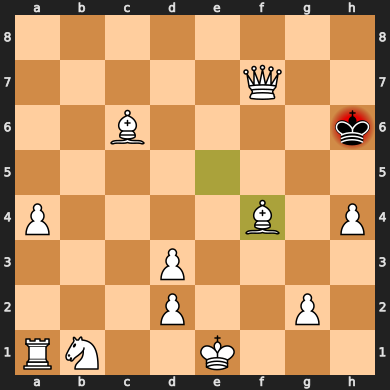

🏁 KẾT QUẢ: 1-0
Trắng thắng!


In [ ]:
#BOT RL VS MINIMAX
from IPython.display import display, clear_output
import chess
import random
import time

PIECE_VALUES = {
    chess.PAWN: 100, chess.KNIGHT: 320, chess.BISHOP: 330,
    chess.ROOK: 500, chess.QUEEN: 900, chess.KING: 20000
}

def evaluate_board_minimax(board):
    if board.is_checkmate():
        if board.turn == chess.WHITE: return -999999
        else: return 999999
    if board.is_stalemate() or board.is_insufficient_material(): return 0

    score = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            val = PIECE_VALUES.get(piece.piece_type, 0)
            if piece.color == chess.WHITE: score += val
            else: score -= val
    return score

def minimax_alpha_beta(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return evaluate_board_minimax(board)

    legal_moves = list(board.legal_moves)
    legal_moves.sort(key=lambda move: board.is_capture(move), reverse=True)

    if maximizing_player:
        max_eval = -float('inf')
        for move in legal_moves:
            board.push(move)
            eval = minimax_alpha_beta(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha: break
        return max_eval
    else:
        min_eval = float('inf')
        for move in legal_moves:
            board.push(move)
            eval = minimax_alpha_beta(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha: break
        return min_eval

def get_best_move_minimax(board, depth=2):
    best_move = None
    max_eval = -float('inf')
    min_eval = float('inf')
    alpha = -float('inf')
    beta = float('inf')

    legal_moves = list(board.legal_moves)
    random.shuffle(legal_moves) 
    legal_moves.sort(key=lambda move: board.is_capture(move), reverse=True)

    is_maximizing = (board.turn == chess.WHITE)

    for move in legal_moves:
        board.push(move)
        val = minimax_alpha_beta(board, depth - 1, alpha, beta, not is_maximizing)
        board.pop()

        if is_maximizing:
            if val > max_eval:
                max_eval = val
                best_move = move
            alpha = max(alpha, val)
        else:
            if val < min_eval:
                min_eval = val
                best_move = move
            beta = min(beta, val)

    return best_move if best_move else random.choice(legal_moves)

def watch_bot_vs_minimax(trainer, minimax_depth=2, delay=0.5):
    board = chess.Board()
    rl_plays_white = random.choice([True, False])

    print(f"⚔️ RL Bot ({'Trắng' if rl_plays_white else 'Đen'}) vs Minimax ({'Đen' if rl_plays_white else 'Trắng'})")
    time.sleep(2)

    move_count = 0
    prev_board = None

    while not board.is_game_over() and move_count < 200:
        clear_output(wait=True)
        display(board)

        turn_name = "Trắng" if board.turn == chess.WHITE else "Đen"
        is_rl_turn = (board.turn == chess.WHITE) == rl_plays_white

        print(f"Nước {move_count+1}: {turn_name} đang đi...")

        if is_rl_turn:
            # === RL BOT ===
            policy = trainer.mcts.search(board, num_simulations=50, temperature=1.0, prev_board=prev_board, root_noise=False)
            legal_moves = list(board.legal_moves)
            legal_probs = [policy[trainer.converter.encode_move(m.uci())] if trainer.converter.encode_move(m.uci()) is not None else 0.0 for m in legal_moves]

            if sum(legal_probs) > 0:
                chosen = legal_moves[np.argmax(legal_probs)]
            else:
                chosen = random.choice(legal_moves)

            print(f"🤖 RL Bot chọn: {board.san(chosen)}")
            prev_for_next = board.copy()
            board.push(chosen)
            prev_board = prev_for_next
        else:
            # === MINIMAX ===
            move = get_best_move_minimax(board, depth=minimax_depth)

            print(f"♟️ Minimax chọn: {board.san(move)}")
            prev_for_next = board.copy()
            board.push(move)
            prev_board = prev_for_next

        move_count += 1
        time.sleep(delay) # Delay for viewing

    clear_output(wait=True)
    display(board)
    print(f"🏁 KẾT QUẢ: {board.result()}")
    if board.is_game_over():
        if board.result() == "1-0": print("Trắng thắng!")
        elif board.result() == "0-1": print("Đen thắng!")
        else: print("Hòa!")

# Demo depth 2
watch_bot_vs_minimax(trainer, minimax_depth=2, delay=0.3)